In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import random
from IPython.display import display
from collections import defaultdict
from itertools import islice

In [64]:
# read in + a little bit of cleaning
df = pd.read_csv('../data/text/sample20.txt', sep='\t')
df = df.set_axis(["Time", "Channel", "Signal", "Source", "Dest", "Seq", "SSID", "BSSID"], axis=1)
df["RTime"] = df["Time"] - df["Time"][0]
df = df[["Time", "RTime", "Channel", "Signal", "Seq", "Source", "Dest", "SSID", "BSSID"]]
df = df.drop(["SSID", "BSSID"], axis=1)
df = df.replace("<MISSING>", np.NaN)


# map our channels
freq_map = {2412: 1, 2437: 6, 2462: 11}
df = df.replace({"Channel": freq_map})


display(df)

,Time,RTime,Channel,Signal,Seq,Source,Dest
0,1.667415e+09,0.000000,6,-93.0,1932.0,ee:b0:36:82:b5:bc,ff:ff:ff:ff:ff:ff
1,1.667415e+09,0.020600,6,-91.0,1933.0,ee:b0:36:82:b5:bc,ff:ff:ff:ff:ff:ff
2,1.667415e+09,0.077403,6,-89.0,1027.0,1e:9d:26:88:08:a1,ff:ff:ff:ff:ff:ff
3,1.667415e+09,0.101553,6,-93.0,1028.0,1e:9d:26:88:08:a1,ff:ff:ff:ff:ff:ff
4,1.667415e+09,0.178932,11,-87.0,2551.0,"2c:17:72:83:ec:a4,2c:17:72:83:ec:a4",NaN
...,...,...,...,...,...,...,...
93596,1.667419e+09,3762.706455,1,-97.0,152.0,a4:83:e7:62:09:23,ff:ff:ff:ff:ff:ff
93597,1.667419e+09,3762.746851,6,-68.0,3723.0,ce:0f:b4:ce:d4:93,ff:ff:ff:ff:ff:ff
93598,1.667419e+09,3762.768871,6,-65.0,3724.0,ce:0f:b4:ce:d4:93,ff:ff:ff:ff:ff:ff
93599,1.667419e+09,3762.799703,1,-88.0,2613.0,4a:75:3c:73:ae:e7,ff:ff:ff:ff:ff:ff


Let's get rid of any 96 bit MAC addresses.

In [65]:
# df = df[ df["Source"].str.len() < 20]
# df = df[ df["Dest"].str.len() < 20]

If we take a look at the probe requests that come in over 5 minutes, we can see that there appears to be a constant stream of them, which makes separating probe requests into buckets rather difficult:

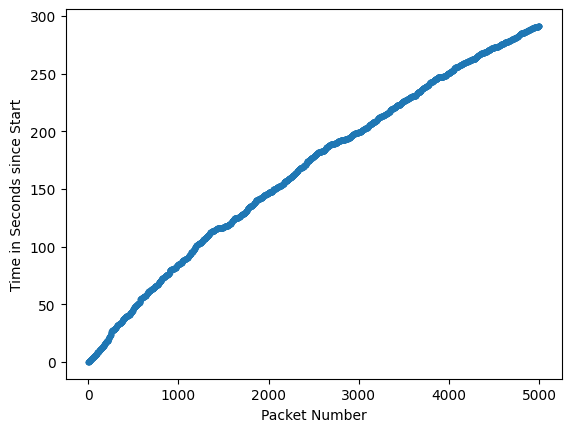

In [66]:
ax = df.iloc[0:5000]["RTime"].plot(style=".")
ax.set_ylabel("Time in Seconds since Start")
ax.set_xlabel("Packet Number")
plt.show()

Let's use our previous value of -45 and see what we come up with

In [69]:
cutoff = -42
filtered = df[df["Signal"] > cutoff]
display(filtered)

,Time,RTime,Channel,Signal,Seq,Source,Dest
1432,1.667415e+09,115.675633,6,-33.0,1502.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1433,1.667415e+09,115.753851,6,-38.0,1507.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1434,1.667415e+09,115.755477,6,-36.0,1508.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1436,1.667415e+09,115.794135,6,-36.0,1510.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1437,1.667415e+09,115.795554,6,-37.0,1511.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
...,...,...,...,...,...,...,...
91692,1.667418e+09,3662.680313,6,-37.0,948.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
91693,1.667418e+09,3662.681734,6,-39.0,949.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
91695,1.667418e+09,3662.683328,6,-36.0,950.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
91696,1.667418e+09,3662.718581,6,-39.0,951.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff


Only 420 entries! Let's see if theres any source MAC that shows up multiple times:

In [71]:
filtered.groupby("Source")["Time"].count()

Source
70:c1:9a:9b:b0:87      1
74:a8:85:54:7c:80      1
a3:10:c7:cb:b5:20      1
c7:26:2d:cc:28:16      1
d1:a1:16:87:62:41      1
e0:cd:8f:73:b0:20      1
e8:10:17:85:0c:b3      1
e8:10:eb:01:04:91      1
e8:50:8b:43:b1:20    411
fa:50:8b:43:60:95      1
Name: Time, dtype: int64

With a cutoff of -42, we can see that our target phone shows up 411 times while also have very little noise. We'll want to tweak this so we don't remove all of the other phones (since we're trying to capture it naturally). At this point, we can group together timestamps to form our clusters. We won't be using any fancy stats to separate them for now, and instead requests into clusters that are atleast 5 seconds away from the next probe.

In [75]:
x = df["RTime"].to_numpy()
dt  = np.diff(x)

print(dt)
pos = np.where(dt > 5)[0] + 1
split = list(np.split(x, pos))

res = []
sizes = []
for x in split:
    if len(x) > 1:
        res.append([int(np.mean(x)), len(x)])
        
        

su = DataFrame(res, columns=["Time", "nRequests"])
su["Diff"] = su.diff()["Time"]
sf = su[su["nRequests"] > 5]
display(sf)

[0.02059984 0.05680299 0.02415013 ... 0.02201986 0.03083205 0.02005696]


,Time,nRequests,Diff
0,1802,93601,NaN
